In [1]:
!pip install pyyaml
!pip install dndice
!pip install python-i18n
!pip install gymnasium
!pip install inflect
!pip install collections-extended
!pip install openai
!pip install -e ..
!pip install ipywidgets
!pip install iprogress


Obtaining file:///home/jedld/workspace/natural_20.py
  Preparing metadata (setup.py) ... done
  Attempting uninstall: natural20.py
    Found existing installation: natural20.py 0.1
    Uninstalling natural20.py-0.1:
      Successfully uninstalled natural20.py-0.1
  Running setup.py develop for natural20.py


In [2]:
from gymnasium import make
from model import QNetwork
from natural20.gym.dndenv import dndenv
from torchsummary import summary
import torch
import tqdm as tqdm
import tqdm.notebook as tqdm
import random
import torch.optim as optim
import torch.nn as nn
import gc
import numpy as np
import sys
import collections

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Show info about the environment and a render of the tabletop map

In [4]:
env = make("dndenv-v0", root_path="map_with_obstacles", show_logs=True, damaged_based_reward=True, render_mode="ansi")
env.reset()
print(env.render())
print(env.observation_space)
print(env.action_space.sample)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'fighter': 1}
hp: 24
max hp: 24
ac: 18
speed: 30



==== Player Character ====
name: rumblebelly
level: 1
character class: {'fighter': 1}
hp: 24
max hp: 24
ac: 18
speed: 30



rumblebelly starts their turn.
rumblebelly tried to attack gomerin with Longbow but missed with (7) + 7= 14.
rumblebelly moved to [3, 1] 1 feet
rumblebelly moved to [3, 2] 1 feet
rumblebelly moved to [4, 3] 1 feet
rumblebelly moved to [4, 4] 1 feet
rumblebelly moved to [4, 3] 1 feet
rumblebelly uses second wind to recover (2) + 1=3 hit points.
no move for rumblebelly
==== current turn gomerin 24/24===
gomerin starts their turn.
____________
____________
_......_____
_ ....._____
_   ..._____
_   #E._____
_.....P_____
_......_____
____________
____________
____________
____________
Dict('ability_info': Box(0, 1, (8,), int64), 'enemy_reactions': Box(0, 1, (1,), int64),

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int64, actual type: float64
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:318: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


DQN Parameters

In [5]:
TRAJECTORY_POLICY = "e-greedy"
NUM_UPDATES = 2
TEMP_DECAY = 0.999
BUFFER_CAPACITY = 2000
FRAMES_TO_STORE = 2
MAX_STEPS = 2000
BATCH_SIZE = 64
TARGET_UPDATE_FREQ = 1
T_HORIZON = 2048
EPSILON_START = 1.0
EPSILON_FINAL = 0.02
EPSILON_DECAY_FRAMES = 10**3
EVAL_STEPS = 20

In [6]:
model = QNetwork(device=device)
model.to(device)
state, info = env.reset()
moves = info["available_moves"]
model.eval()
print(model(state, moves[0]))

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'fighter': 1}
hp: 24
max hp: 24
ac: 18
speed: 30



==== Player Character ====
name: rumblebelly
level: 1
character class: {'fighter': 1}
hp: 24
max hp: 24
ac: 18
speed: 30



rumblebelly starts their turn.
rumblebelly attacked gomerin with Longbow and hits with (12) + 7= 19.
gomerin took 13 damage.
rumblebelly moved to [4, 2] 1 feet
rumblebelly moved to [4, 3] 1 feet
rumblebelly moved to [3, 4] 1 feet
rumblebelly moved to [2, 4] 1 feet
rumblebelly moved to [2, 5] 1 feet
rumblebelly uses second wind to recover (4) + 1=5 hit points.
no move for rumblebelly
==== current turn gomerin 11/24===
gomerin starts their turn.
tensor([[-0.1716]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [7]:
def act_with_policy(state, info, model, policy='e-greedy', temperature=5.0, epsilon=0.1):
    available_moves = info["available_moves"]
    with torch.no_grad():
        if policy == 'boltzmann':
            values = torch.stack([model(state, move).squeeze() for move in available_moves])
            if len(values) > 1:
                if temperature != 0:
                    values = values / temperature
                else:
                    raise ValueError("Temperature is zero, which can lead to division by zero.")

                # Stabilizing the exponential calculation
                values = values - torch.max(values)  # Subtract the max value for numerical stability
                values = torch.exp(values)
                sum_values = torch.sum(values)

                if sum_values > 0:
                    values = values / sum_values
                    chosen_index = torch.multinomial(values, 1).item()
                else:
                    print("Sum of exponentiated values is zero. Adjust the model or input.")
                    chosen_index = torch.randint(len(available_moves), (1,)).item()
            else:
                chosen_index = 0
        elif policy == 'e-greedy':
            if random.random() < epsilon:
                chosen_index = random.choice(range(len(available_moves)))
            else:
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        elif policy == 'greedy':
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        else:
            raise ValueError(f"Unknown policy: {policy}")
    
    return available_moves[chosen_index]

def generate_trajectory(env, model, policy='e-greedy', temperature=5.0, epsilon=0.1, horizon=2048, quick_exit=False):
    state, info = env.reset()
    done = False
    truncated = False
    states = []
    actions = []
    rewards = []
    dones = []
    truncateds = []
    infos = []
    truncated = False
    for _ in range(horizon):
        # instead of sampling  (e.g. env.action_space.sample()) we can ask help from the enivronment to obtain valid moves
        # as there are sparse valid moves in the environment
        action = act_with_policy(state, info, model, policy, temperature, epsilon)
        next_state, reward, done, truncated, next_info = env.step(action)       
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        truncateds.append(truncated)
        infos.append(info)

        if done:
            break    
        if truncated:
            truncated = True
            break
        state = next_state
        info = next_info
        
    states.append(next_state)
    infos.append(next_info)
    actions.append((-1, (0,0), (0,0), 0))
    return states, actions, rewards, dones, truncateds, infos

In [8]:
trajectory = generate_trajectory(env, model, epsilon=1.0)
print(trajectory)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'fighter': 1}
hp: 24
max hp: 24
ac: 18
speed: 30



==== Player Character ====
name: rumblebelly
level: 1
character class: {'fighter': 1}
hp: 24
max hp: 24
ac: 18
speed: 30



gomerin starts their turn.
gomerin starts their turn.
gomerin dashes.
gomerin uses second wind to recover (2) + 1=3 hit points.
==== end turn ===
gomerin 24/24
rumblebelly 24/24
rumblebelly starts their turn.
==== current turn rumblebelly 24/24===
rumblebelly moved to [1, 4] 1 feet
rumblebelly moved to [0, 3] 1 feet
rumblebelly moved to [1, 2] 1 feet
rumblebelly moved to [2, 1] 1 feet
rumblebelly moved to [2, 0] 1 feet
rumblebelly uses second wind to recover (10) + 1=11 hit points.
no move for rumblebelly
==== current turn gomerin 24/24===
gomerin starts their turn.
Result: False
rumblebelly tried to attack gomerin with opportunity with Rapier but missed with (6) + 7

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int64, actual type: float64
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [9]:
EPISODES = 10
total_rewards = 0
for i in tqdm.tqdm(range(EPISODES)):
    states, actions, rewards, dones, truncateds, infos = generate_trajectory(env, model, epsilon=1.0)
    total_rewards += sum(rewards)

avg_reward = total_rewards/EPISODES
print(f"Average reward: {avg_reward} Total Reward: {total_rewards}")

  0%|          | 0/10 [00:00<?, ?it/s]

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'fighter': 1}
hp: 24
max hp: 24
ac: 18
speed: 30



==== Player Character ====
name: rumblebelly
level: 1
character class: {'fighter': 1}
hp: 24
max hp: 24
ac: 18
speed: 30



rumblebelly starts their turn.
rumblebelly tried to attack gomerin with Longbow but missed with (3) + 7= 10.
rumblebelly moved to [4, 3] 1 feet
rumblebelly moved to [3, 2] 1 feet
rumblebelly moved to [2, 1] 1 feet
rumblebelly moved to [2, 0] 1 feet
rumblebelly moved to [2, 1] 1 feet
rumblebelly uses second wind to recover (4) + 1=5 hit points.
no move for rumblebelly
==== current turn gomerin 24/24===
gomerin starts their turn.
gomerin moved to [4, 1] 1 feet
gomerin dodges.
gomerin moved to [5, 1] 1 feet
==== end turn ===
gomerin 24/24
rumblebelly 24/24
rumblebelly starts their turn.
==== current turn rumblebelly 24/24===
rumblebelly tried to attack gomerin with disa

In [10]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, states, actions, rewards, infos, is_terminal):
        self.buffer.append((states, actions, rewards, infos, is_terminal))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size)
        states, actions, rewards, infos, is_terminals = zip(*[self.buffer[idx] for idx in indices])
        return states, actions, rewards, infos, is_terminals

    def __len__(self):
        return len(self.buffer)
    
    # memory usage of the buffer in bytes
    def memory_usage(self):
        total_size = 0
        for item in self.buffer:
            states, actions, rewards, infos, is_terminals = item
            for s in states:
                total_size += sys.getsizeof(s)
            total_size += sys.getsizeof(actions)
            total_size += sys.getsizeof(rewards)
            total_size += sys.getsizeof(infos)
            total_size += sys.getsizeof(is_terminals)

        return total_size

In [11]:
# generate a batch of trajectories and store them in the replay buffer
def generate_batch_trajectories(env, model, n_rollout, replay_buffer: ReplayBuffer, temperature=5.0, epsilon=0.1, horizon=30, policy='e-greedy'):
    # print(f"generating {n_rollout} rollouts")
    for _ in range(n_rollout):
        state, action, reward, done, truncated, info = generate_trajectory(env, model, temperature=temperature,
                                                                           epsilon=epsilon,
                                                                           horizon=horizon,policy=policy)
        replay_buffer.push(state, action, reward, info, done or truncated)

In [12]:
def train(env, gamma, learning_rate, max_steps=MAX_STEPS, use_td_target=True,
          trajectory_policy='e-greedy',
          label="dnd_egreedy",
          n_rollout=8,
          seed=1337):
  print(f"training with gamma {gamma} and learning rate {learning_rate}")
  env.seed(seed)

  replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
  # load model checkpoint if available
  model = QNetwork(device).to(device)
  target_model = QNetwork(device).to(device)

  # intialize target network with the same weights as the model
  target_model.load_state_dict(model.state_dict())

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  best_avg = -10
  best_step = 0
  temperature = 5.0
  reward_per_episode = []
  epsilon = EPSILON_START

  for step in tqdm.tqdm(range(max_steps)):
    # if trajectory_policy == 'boltzmann':
    #   print(f"step {step} t={temperature}")
    # if trajectory_policy == 'softmax':
    #   print(f"step {step} t={temperature}")
    # elif trajectory_policy == 'e-greedy':
    #   print(f"step {step} epsilon={epsilon}")
    # else:
    #   print(f"step {step}")
    generate_batch_trajectories(env, model, n_rollout, replay_buffer, temperature=temperature,
                                epsilon=epsilon, policy=trajectory_policy, horizon=T_HORIZON)

    states, actions, rewards, infos, is_terminals = replay_buffer.sample(BATCH_SIZE)
    rewards_collected = 0
    for _ in range(NUM_UPDATES):
      rewards_collected = 0
      total_loss = 0.0
      
      for i in range(len(states)):
        s = states[i]
        a = actions[i]
        env_info = infos[i]
        r = torch.tensor(rewards[i]).to(device).unsqueeze(1)
        is_terminal = torch.tensor(is_terminals[i]).float().to(device).unsqueeze(1)
        
        if use_td_target:
          with torch.no_grad():
            s_next = s[1:]
            a_next = a[1:]
            q_targets = target_model(s_next, a_next).detach()
        else: # Q-learning target == "slow"
          with torch.no_grad():
            q_targets = torch.zeros(len(env_info)).to(device)
            s_next = s[1:]
            env_info = infos[1:]
            for index, (state, info) in enumerate(zip(s_next, env_info)):
              total_available_moves = len(info["available_moves"])
              states = [state] * total_available_moves
              avail_actions = info["available_moves"]
              q_values = target_model(states, avail_actions).detach()
              
              if len(q_values) == 0:
                q_targets[index] = 0
              else:
                q_targets[index] = torch.max(torch.stack(q_values)).item()
        targets = r + gamma * q_targets * (1 - is_terminal)
        
        s = s[0:-1]
        a = a[0:-1]
        output = model(s, a)
        q_sa = output

        value_loss = nn.MSELoss()(q_sa, targets)
        optimizer.zero_grad()
        value_loss.backward()
        total_loss += value_loss.item()
        rewards_collected += r.sum().item()
        optimizer.step()

    # save model checkpoint

    if step % 10 == 0:
      # torch.save(model.state_dict(), f"model_{step}.pt")
      eval_rewards = []
      for _ in range(EVAL_STEPS):
        _, _, rewards, _, _, _ = generate_trajectory(env, model, policy='greedy')
        total_reward = sum(rewards)
        eval_rewards.append(total_reward)
        
      avg_rewards = np.mean(eval_rewards)
      # print(f"eval rewards: {avg_rewards}")
      reward_per_episode.append(avg_rewards)

      # print(f"total reward: {total_reward}")
      print(f"{step}: avg rewards {avg_rewards} best avg {best_avg}@{best_step}")

      if avg_rewards > best_avg:
        print(f"best: {avg_rewards}")
        best_avg = avg_rewards
        best_step = step
        torch.save(model.state_dict(), f"model_best_{label}.pt")

      torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}.pt")


    if step % 100 == 0:
      torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}_{step}.pt")


    gc.collect()
    
    # decay temp
    temperature = np.max([0.1, temperature * TEMP_DECAY])

    # decay epsilon
    epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1.0 * step / EPSILON_DECAY_FRAMES)

    if step % TARGET_UPDATE_FREQ == 0:
      # calculate the avg change weights of the model with the target model
      total_change = 0
      for p, p_target in zip(model.parameters(), target_model.parameters()):
        total_change += torch.abs(p - p_target).sum().item()
      # print(f"total change: {total_change}")

      target_model.load_state_dict(model.state_dict())

  env.close()
  return reward_per_episode


Specify the location of the game configuration

In [13]:
game_setup_path = "map_with_obstacles"

Create the env setup. Note that we use damaged based rewards to give a denser reward signalling.

In [14]:
def make_env(root_path):
    return make("dndenv-v0", root_path=root_path, show_logs=False, damage_based_reward=True)

In [15]:
env = make_env(game_setup_path)

In [16]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.0001]
gammas = [0.99]

results = {}
for lr in learning_rates:
  results[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed)
    results[lr][gamma] = reward_per_episode


training with gamma 0.99 and learning rate 0.0001


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int64, actual type: float64
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int64, actual type: float64
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/si

0: avg rewards -10.0 best avg -10@0
10: avg rewards -10.0 best avg -10@0
20: avg rewards -9.729166666666668 best avg -10@0
best: -9.729166666666668
30: avg rewards -10.0 best avg -9.729166666666668@20
40: avg rewards -9.854166666666668 best avg -9.729166666666668@20
50: avg rewards -9.833333333333332 best avg -9.729166666666668@20
60: avg rewards -8.125 best avg -9.729166666666668@20
best: -8.125
70: avg rewards -6.479166666666667 best avg -8.125@60
best: -6.479166666666667
80: avg rewards -5.833333333333334 best avg -6.479166666666667@70
best: -5.833333333333334
90: avg rewards -7.833333333333333 best avg -5.833333333333334@80
100: avg rewards -7.416666666666666 best avg -5.833333333333334@80
110: avg rewards -7.104166666666666 best avg -5.833333333333334@80
120: avg rewards -7.062500000000002 best avg -5.833333333333334@80
130: avg rewards -4.4375 best avg -5.833333333333334@80
best: -4.4375
140: avg rewards -7.3125 best avg -4.4375@130
150: avg rewards -4.916666666666666 best avg -4

/home/jedld/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


1920: avg rewards 9.0 best avg 10.0@1200
1930: avg rewards 10.0 best avg 10.0@1200
1940: avg rewards 8.916666666666668 best avg 10.0@1200
1950: avg rewards 6.083333333333333 best avg 10.0@1200
1960: avg rewards 10.0 best avg 10.0@1200
1970: avg rewards 8.25 best avg 10.0@1200
1980: avg rewards 10.0 best avg 10.0@1200
1990: avg rewards 8.5 best avg 10.0@1200


Summarize rewards per episode

In [17]:
for item in results:
  for gamma in results[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results[item][gamma]}")

lr: 0.0001 gamma: 0.99 rewards: [-10.0, -10.0, -9.729166666666668, -10.0, -9.854166666666668, -9.833333333333332, -8.125, -6.479166666666667, -5.833333333333334, -7.833333333333333, -7.416666666666666, -7.104166666666666, -7.062500000000002, -4.4375, -7.3125, -4.916666666666666, -5.270833333333334, 1.1250000000000002, -4.375, -5.229166666666666, 0.4166666666666667, -5.8125, -3.25, -2.6874999999999996, -2.145833333333333, -1.8541666666666665, -3.854166666666667, -1.7916666666666667, -4.9375, -2.2291666666666665, -2.541666666666667, -2.583333333333333, -4.270833333333333, -2.3125, -3.166666666666667, -1.0000000000000002, -2.5, -3.229166666666667, -2.145833333333333, 1.0, 0.41666666666666696, 0.10416666666666678, 0.9166666666666664, 1.75, 1.125, 2.7916666666666665, 0.5208333333333333, 2.125, -2.7083333333333335, 2.8750000000000004, 2.8541666666666665, 0.7499999999999999, 0.7291666666666667, 0.6458333333333335, 1.4791666666666665, 3.5, 3.8125, 4.5, 2.583333333333333, 0.5833333333333333, 4.

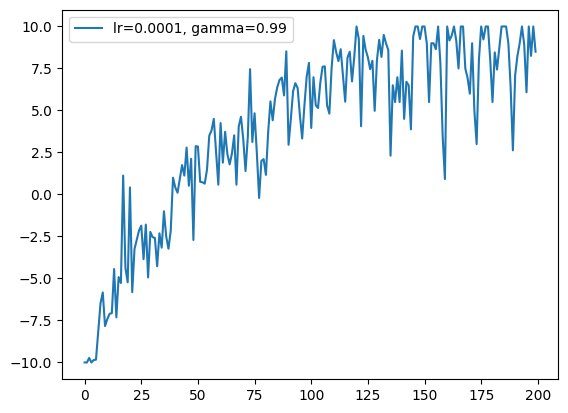

In [18]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()


In [19]:
env = make_env(game_setup_path)

In [20]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.001]
gammas = [0.99]

results = {}
for lr in learning_rates:
  results[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, trajectory_policy='boltzmann', label="boltzmann")
    results[lr][gamma] = reward_per_episode

training with gamma 0.99 and learning rate 0.001


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int64, actual type: float64
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int64, actual type: float64
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


0: avg rewards -9.791666666666668 best avg -10@0
best: -9.791666666666668
10: avg rewards -4.875000000000001 best avg -9.791666666666668@0
best: -4.875000000000001
20: avg rewards -2.8125000000000004 best avg -4.875000000000001@10
best: -2.8125000000000004
30: avg rewards -5.208333333333333 best avg -2.8125000000000004@20
40: avg rewards -2.4166666666666665 best avg -2.8125000000000004@20
best: -2.4166666666666665
50: avg rewards -4.083333333333333 best avg -2.4166666666666665@40
60: avg rewards -4.583333333333333 best avg -2.4166666666666665@40
70: avg rewards -3.583333333333333 best avg -2.4166666666666665@40
80: avg rewards -3.500000000000001 best avg -2.4166666666666665@40
90: avg rewards -4.8125 best avg -2.4166666666666665@40
100: avg rewards -3.4791666666666665 best avg -2.4166666666666665@40
110: avg rewards 0.6041666666666667 best avg -2.4166666666666665@40
best: 0.6041666666666667
120: avg rewards -0.4583333333333332 best avg 0.6041666666666667@110
130: avg rewards -0.3958333

In [ ]:
for item in results:
  for gamma in results[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results[item][gamma]}")

In [ ]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()